In [23]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

<div dir="rtl">
# مسیر اصلی داده‌ها
</div>

In [24]:
data_dir = 'food_data'

<div dir="rtl">
# تعیین ابعاد تصاویر برای تغییر سایز
<br/>
# با توجه به اینکه ابعاد عکس‌ها یکسان نیستند ، باید یک اندازه استاندارد برای ورودی مدل تعیین کنیم.
<br/>
# برای شروع، ابعاد 224x224 پیکسل می‌کنیم.
</div>

In [25]:
img_height, img_width = 224, 224

<div dir="rtl">
# تعیین Batch Size
<br/>
# اندازه دسته‌هایی (batch size) که به مدل می‌دهید، یکی از هایپرپارامترهای مهم است.
<br/>
#  32 را انتخاب می‌کنیم  بسته به سیستم و توان پردازش شما می‌تواند تغییر کند.
</div>

In [26]:
batch_size = 32

<div dir="rtl">
# پیکربندی ImageDataGenerator برای Data Augmentation و تقسیم‌بندی داده‌ها
<br/>
# در صورت احتمال بیش‌برازش از تکنیک‌های تقویت داده (Data Augmentation) استفاده کنید.
<br/>
# همچنین تصاویر را به دو دسته‌ی آموزشی و اعتبارسنجی تقسیم می‌کنیم.
</div>

In [27]:
train_datagen = ImageDataGenerator(
    rescale=1./255, # نرمال‌سازی مقادیر پیکسل بین 0 و 1
    validation_split=0.2, # 20% داده‌ها برای اعتبارسنجی
    rotation_range=20, # چرخش تصادفی تا 20 درجه
    width_shift_range=0.2, # شیفت افقی تصادفی
    height_shift_range=0.2, # شیفت عمودی تصادفی
    horizontal_flip=True, # فلیپ افقی تصادفی
    zoom_range=0.2 # زوم تصادفی
)

<div dir="rtl">
# ImageDataGenerator برای داده‌های اعتبارسنجی (بدون Data Augmentation)
</div>

In [28]:
validation_datagen = ImageDataGenerator(
    rescale=1./255, # فقط نرمال‌سازی
    validation_split=0.2 # همانند train_datagen برای حفظ consistency در تقسیم‌بندی
)


<div dir="rtl">
# خواندن تصاویر و تقسیم‌بندی به داده‌های آموزشی
</div>

In [29]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # برای دسته‌بندی چندکلاسه
    subset='training' # استفاده از زیرمجموعه آموزشی
)

Found 19276 images belonging to 22 classes.


<div dir="rtl">
# خواندن تصاویر و تقسیم‌بندی به داده‌های اعتبارسنجی
</div>

In [30]:
validation_generator = validation_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical', # برای دسته‌بندی چندکلاسه
    subset='validation' # استفاده از زیرمجموعه اعتبارسنجی
)

Found 4808 images belonging to 22 classes.


<div dir="rtl">
# نمایش تعداد کلاس‌ها و نمونه‌ها در هر مجموعه
</div>

In [31]:
print(f"تعداد کلاس‌ها: {train_generator.num_classes}")
print(f"کلاس‌ها: {train_generator.class_indices}")
print(f"تعداد تصاویر در مجموعه آموزش: {train_generator.samples}")
print(f"تعداد تصاویر در مجموعه اعتبارسنجی: {validation_generator.samples}")

تعداد کلاس‌ها: 22
کلاس‌ها: {'baked_potato': 0, 'baklava': 1, 'caesar_salad': 2, 'cheese_sandwich': 3, 'cheesecake': 4, 'chicken': 5, 'chicken_curry': 6, 'chocolate_cake': 7, 'donuts': 8, 'eggs': 9, 'falafel': 10, 'fish': 11, 'french_fries': 12, 'hamburger': 13, 'hot_dog': 14, 'ice_cream': 15, 'lasagna': 16, 'omelette': 17, 'pizza': 18, 'spaghetti': 19, 'steak': 20, 'sushi': 21}
تعداد تصاویر در مجموعه آموزش: 19276
تعداد تصاویر در مجموعه اعتبارسنجی: 4808


<div dir="rtl">
# تعریف تعداد کلاس‌ها از ژنراتور آموزش
</div>

In [32]:
num_classes = train_generator.num_classes

<div dir="rtl">
# بارگذاری مدل MobileNetV2
<br/>
# شامل لایه‌های بالای مدل (include_top=False) را حذف می‌کنیم تا لایه‌های خودمان را اضافه کنیم.
</div>

In [33]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

<div dir="rtl">
# فریز کردن لایه‌های مدل پایه
<br/>
# این کار از آموزش مجدد وزن‌های مدل پایه جلوگیری می‌کند و تنها لایه‌های جدید ما آموزش می‌بینند.
</div>

In [34]:
for layer in base_model.layers:
    layer.trainable = False

<div dir="rtl">
# اضافه کردن لایه‌های جدید برای مسئله دسته‌بندی غذای ما
</div>

In [35]:
x = base_model.output
x = GlobalAveragePooling2D()(x) # تبدیل خروجی لایه‌های پیچیده به یک بردار یک‌بعدی
x = Dense(1024, activation='relu')(x) # یک لایه Dense با تابع فعال‌سازی ReLU
predictions = Dense(num_classes, activation='softmax')(x) # لایه خروجی با تعداد کلاس‌های ما و تابع فعال‌سازی Softmax

<div dir="rtl">
# ساخت مدل نهایی
</div>

In [36]:
model = Model(inputs=base_model.input, outputs=predictions)

<div dir="rtl">
# تنظیم هایپرپارامترها: نرخ یادگیری (Learning Rate) و بهینه‌ساز (Optimizer)
<br/>
# نرخ یادگیری (Learning Rate)  0.0001 را انتخاب می‌کنیم .
<br/>
# بهینه‌ساز Adam .

</div>

In [37]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

<div dir="rtl">
# کامپایل کردن مدل
<br/>
# معیار ارزیابی ما برای این پروژه f1_score میکرو است، اما برای آموزش مدل،ً از 'accuracy' به عنوان متریک پایش  استفاده کردیم چون سبک تر است.
<br/>
# loss function نیز 'categorical_crossentropy' است که برای دسته‌بندی چندکلاسه مناسب است.
</div>

In [38]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

<div dir="rtl">
# نمایش خلاصه‌ای از ساختار مدل
</div>

In [39]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,592,278 (13.70 MB)

 Trainable params: 1,334,294 (5.09 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [40]:
print(f"\nمدل MobileNetV2 بارگذاری و لایه‌های جدید اضافه شد.")
print(f"لایه‌های مدل پایه فریز شدند.")
print(f"مدل با نرخ یادگیری {learning_rate} و بهینه‌ساز Adam کامپایل شد.")



مدل MobileNetV2 بارگذاری و لایه‌های جدید اضافه شد.
لایه‌های مدل پایه فریز شدند.
مدل با نرخ یادگیری 0.0001 و بهینه‌ساز Adam کامپایل شد.


<div dir="rtl">
# تنظیم هایپرپارامتر: تعداد دورهای آموزش مدل (epochs)
<br/>
# تعداد epochs  10 epoch را در نظر می‌گیریم.
</div>

In [41]:
epochs = 10

<div dir="rtl">
# اضافه کردن Callbacks برای بهبود فرآیند آموزش
<br/>
# ModelCheckpoint برای ذخیره بهترین مدل بر اساس دقت اعتبارسنجی
</div>

In [42]:
checkpoint_filepath = 'best_model.keras' # پسوند .keras برای ذخیره مدل‌های Keras 3
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # ذخیره کل مدل شامل معماری و بهینه‌ساز
    monitor='val_accuracy', # پایش دقت روی مجموعه اعتبارسنجی
    mode='max', # در حالت max، وقتی val_accuracy بیشتر شد، مدل ذخیره می‌شود.
    save_best_only=True # فقط بهترین مدل را ذخیره کن
)

<div dir="rtl">
# EarlyStopping برای متوقف کردن آموزش اگر دقت اعتبارسنجی برای مدتی بهبود نیافت
</div>

In [43]:
early_stopping_callback = EarlyStopping(
    monitor='val_accuracy', # پایش دقت روی مجموعه اعتبارسنجی
    patience=3, # اگر دقت اعتبارسنجی برای 3 epoch متوالی بهبود نیافت، آموزش متوقف شود.
    mode='max',
    restore_best_weights=True # بهترین وزن‌ها را بازیابی کن
)

print(f"آموزش مدل برای {epochs} دوره (epochs) آغاز می‌شود.")
print(f"بهترین مدل بر اساس val_accuracy در مسیر '{checkpoint_filepath}' ذخیره خواهد شد.")
print(f"آموزش اگر val_accuracy برای 3 دوره متوالی بهبود نیابد، متوقف خواهد شد.")


آموزش مدل برای 10 دوره (epochs) آغاز می‌شود.
بهترین مدل بر اساس val_accuracy در مسیر 'best_model.keras' ذخیره خواهد شد.
آموزش اگر val_accuracy برای 3 دوره متوالی بهبود نیابد، متوقف خواهد شد.


<div dir="rtl">
# آموزش مدل
</div>

In [44]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[model_checkpoint_callback, early_stopping_callback] # اضافه کردن Callbacks
)

print("\nآموزش مدل به پایان رسید.")


Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 308s 506ms/step - accuracy: 0.5158 - loss: 1.7326 - val_accuracy: 0.7369 - val_loss: 0.8964
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 309s 513ms/step - accuracy: 0.7270 - loss: 0.9029 - val_accuracy: 0.7621 - val_loss: 0.8148
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 295s 489ms/step - accuracy: 0.7621 - loss: 0.8029 - val_accuracy: 0.7760 - val_loss: 0.7488
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 295s 489ms/step - accuracy: 0.7718 - loss: 0.7603 - val_accuracy: 0.7673 - val_loss: 0.7767
Epoch 5/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 301s 500ms/step - accuracy: 0.7871 - loss: 0.7028 - val_accuracy: 0.7841 - val_loss: 0.7155
Epoch 6/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 307s 509ms/step - accuracy: 0.7963 - loss: 0.6696 - val_accuracy: 0.7858 - val_loss: 0.7201
Epoch 7/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 305s 507ms/step - accuracy: 0.8064 - loss: 0.6443 - val_accuracy: 0.7864 - val_loss: 0.7100
Epoch 8/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 302s 501ms/step - accuracy: 0.8127 -

<div dir="rtl">
# نمایش نتایج آموزش
</div>

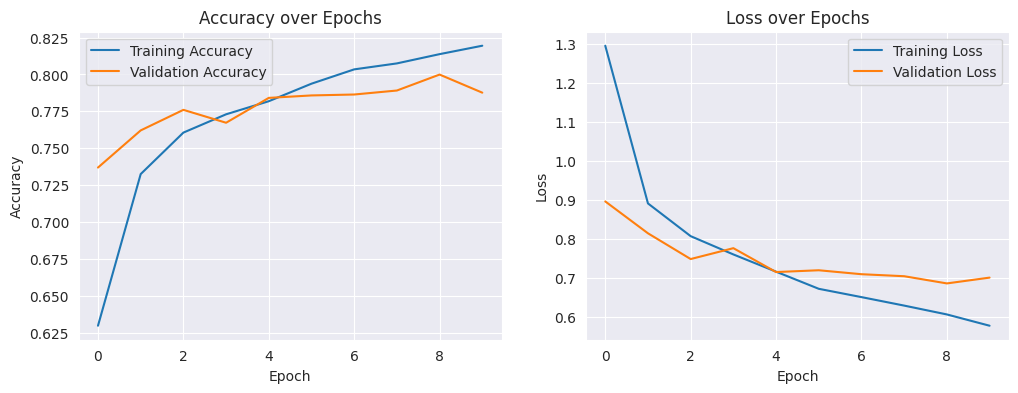

In [45]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

<div dir="rtl">
# بارگذاری  best_model.keras
</div>

In [46]:
try:
    model = load_model('best_model.keras')
    print("مدل با موفقیت از 'best_model.keras' بارگذاری شد.")
except Exception as e:
    print(f"خطا در بارگذاری مدل: {e}")
    exit() # توقف اجرا اگر مدل بارگذاری نشد

مدل با موفقیت از 'best_model.keras' بارگذاری شد.


<div dir="rtl">
# 1. آماده‌سازی برای مجموعه‌داده آزمون (با فرض اینکه مجموعه‌داده آزمون دریافت شده است)
<br/>
# فرض کنید مجموعه‌داده آزمون در یک پوشه به نام 'test_food_data' قرار دارد
<br/>
# این پوشه شامل تصاویر بدون ساختار دسته‌بندی است.
</div>

In [53]:
# test_data_dir = 'test_food_data'

<div dir="rtl">
# ایجاد یک لیست برای نگهداری نام فایل‌های تصاویر آزمون
</div>

In [52]:
# test_image_filenames = []

<div dir="rtl">
# بررسی وجود پوشه test_data_dir
</div>

In [51]:
# if not os.path.exists(test_data_dir):
#     print(f"پوشه مجموعه‌داده آزمون '{test_data_dir}' یافت نشد.")
#     os.makedirs(test_data_dir, exist_ok=True)
#     print("فایل‌های dummy برای نمایش روند ایجاد شدند.")
# else:
#     print(f"پوشه مجموعه‌داده آزمون '{test_data_dir}' یافت شد.")


<div dir="rtl">
# جمع‌آوری نام تمام فایل‌های تصویری در پوشه آزمون
</div>

In [54]:
# for root, _, files in os.walk(test_data_dir):
#     for file in files:
#         if file.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
#             test_image_filenames.append(file)
#
# if not test_image_filenames:
#     print(f"هیچ تصویری در پوشه '{test_data_dir}' یافت نشد.")
# else:
#     # آماده‌سازی لیستی برای ذخیره پیش‌بینی‌ها
#     predictions = []
#     image_names_for_submission = []
#
#     print(f"شروع پیش‌بینی برای {len(test_image_filenames)} تصویر آزمون...")
#
#     # نگاشت ایندکس‌های کلاس به نام‌های کلاس
#     # ایندکس_به_نام کلاس
#     idx_to_class = {v: k for k, v in train_generator.class_indices.items()}
#
#     for filename in test_image_filenames:
#         img_path = os.path.join(test_data_dir, filename)
#         img = image.load_img(img_path, target_size=(img_height, img_width))
#         img_array = image.img_to_array(img)
#         img_array = np.expand_dims(img_array, axis=0) # اضافه کردن بعد batch
#         img_array = img_array / 255.0 # نرمال‌سازی (مانند آموزش)
#
#         # پیش‌بینی با مدل
#         prediction_probs = model.predict(img_array)
#         predicted_class_index = np.argmax(prediction_probs)
#         predicted_class_name = idx_to_class[predicted_class_index]
#
#         predictions.append(predicted_class_name)
#         image_names_for_submission.append(filename)
#
#     # 2. آماده‌سازی فایل CSV
#     submission_df = pd.DataFrame({
#         'name': image_names_for_submission,
#         'predicted': predictions
#     })

<div dir="rtl">
# ذخیره فایل CSV
</div>

In [55]:
# output_filename = 'q1_submission.csv'
# submission_df.to_csv(output_filename, index=False)
#
# print(f"\nفایل خروجی '{output_filename}' با موفقیت ایجاد شد.")
# print("چند ردیف اول فایل خروجی:")
# print(submission_df.head())
